In [12]:
import numpy as np
import pandas as pd
import seaborn as sns     

import matplotlib.pyplot as plt   
import matplotlib as mpl          
mpl.rc('font', family='Malgun Gothic')     
plt.rcParams['axes.unicode_minus']=False


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import FinanceDataReader as fdr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 주식 예측

## 기본 작업

In [15]:
stock=fdr.DataReader('005930', '2020')    # 삼성전자 
stock.shape

(1289, 6)

In [18]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


- 결측치
    - 선형 보간법 : 날짜기 비어 있는 부분을 보간
    - 'D'=일별, 'B'=영업일 기준, 'W'=주별, 'M'=월별

In [327]:
stock=stock.asfreq('B', method='pad')    
stock.shape

(1367, 6)

## SARIMAX 모델

In [336]:
sa_stock=stock.copy()

In [338]:
# 설명(독립)변수 X, 목표(종속)변수 Y
X=sa_stock[['Open', 'High', 'Low']] 
Y=sa_stock['Close']
X.shape, Y.shape

((1367, 3), (1367,))

In [340]:
# 스케일 조절 - 표준화
scaler=StandardScaler()
X_scaler=scaler.fit_transform(X)

In [342]:
X_train, X_test, Y_train, Y_test=train_test_split(X_scaler, Y, test_size=0.2, random_state=42, shuffle=False)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1093, 3), (274, 3), (1093,), (274,))

### 정상성 확인

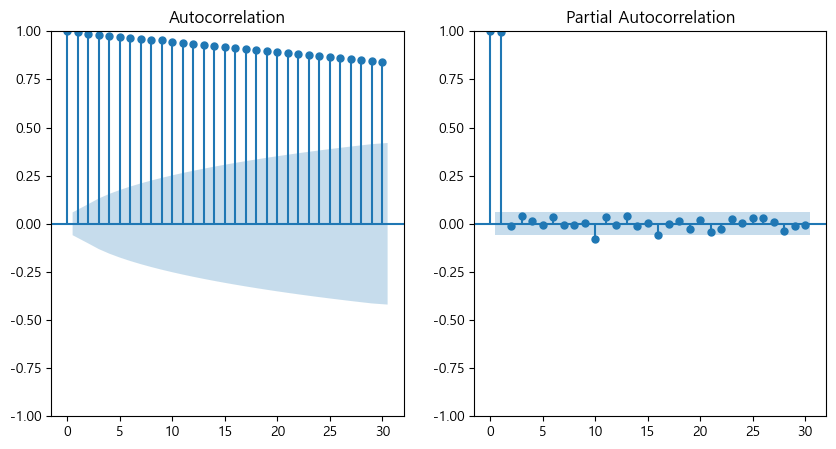

In [345]:
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
plot_acf(Y_train, lags=30, ax=ax[0])
plot_pacf(Y_train, lags=30, ax=ax[1])
plt.show()

In [347]:
result=adfuller(Y_train)
result
print("p-value:", result[1]) 

p-value: 0.3528362534736583


### SARIMAX 모델 학습

In [356]:
# model=SARIMAX(Y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 5))

model=SARIMAX(Y_train, exog=X_train, order=(1, 1, 0))
model_fit=model.fit()

In [352]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1093
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -8257.717
Date:                Sun, 30 Mar 2025   AIC                          16525.435
Time:                        11:11:08   BIC                          16550.414
Sample:                    01-02-2020   HQIC                         16534.888
                         - 03-11-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -6457.9127    167.842    -38.476      0.000   -6786.877   -6128.949
x2          7707.1564    115.886     66.507      0.000    7480.025    7934.288
x3          7434.7011    237.894     31.252      0.000    6968.438    7900.965
ar.L1         -0.3131      0.005    -58.628      0.000      -0.324      -0.303
sigma2      1.963e+05   5497.690     35.713      0.000    1.86e+05    2.07e+05
===================================================================================
Ljung-Box (L1) (Q):                  50.67   Jarque-Bera (JB):              4859.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 평가 및 예측
- start=Y_test.index[0]: 예측 시작점 (테스트 데이터의 첫 번째 인덱스)
- end=Y_test.index[-1]: 예측 종료점 (테스트 데이터의 마지막 인덱스)
- exog=X_test: 외생 변수(설명 변수) 제공

In [358]:
pred=model_fit.predict(start=Y_test.index[0], end=Y_test.index[-1], exog=X_test)
pred

2024-03-12    72866.775447
2024-03-13    73610.569287
2024-03-14    73554.610721
2024-03-15    72628.159472
2024-03-18    72754.363805
                  ...     
2025-03-24    62584.296154
2025-03-25    61664.847316
2025-03-26    62732.508414
2025-03-27    63294.882021
2025-03-28    62157.530501
Freq: B, Name: predicted_mean, Length: 274, dtype: float64

In [360]:
Y_test.tail()

Date
2025-03-24    60500
2025-03-25    59800
2025-03-26    61400
2025-03-27    61800
2025-03-28    60200
Freq: B, Name: Close, dtype: int64

In [362]:
r2_score(Y_test, pred)         # # 평가 - 정확도

0.9712460489139921

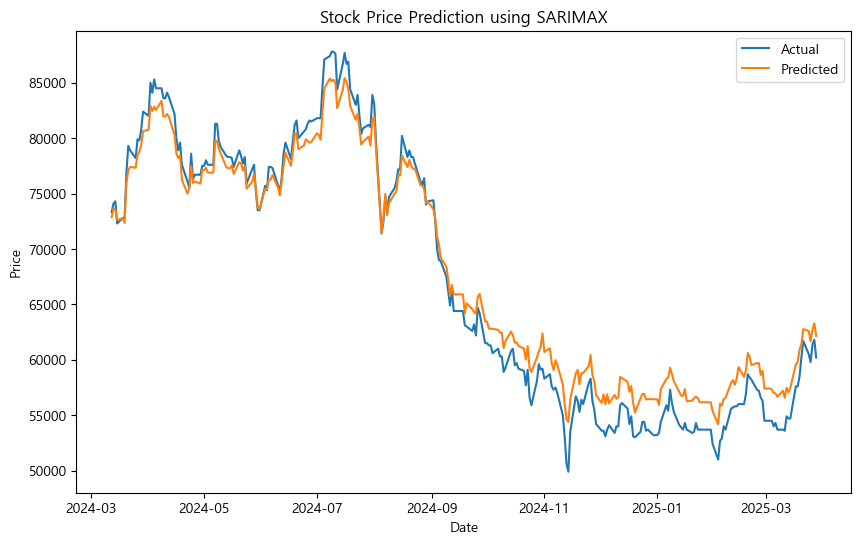

In [364]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual')     # 실제값
plt.plot(Y_test.index, pred, label='Predicted')    # 예측값
plt.title('Stock Price Prediction using SARIMAX')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## 선형회귀

In [20]:
# 기본 작업 참조)
lr_stock=stock.copy()
lr_stock.shape

(1289, 6)

In [22]:
lr_stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


### 전처리
- 차분, 표준화

In [25]:
lr_stock['Close_diff']=lr_stock['Close'].diff()
lr_stock.isnull().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
Change        0
Close_diff    1
dtype: int64

In [27]:
lr_stock.dropna(inplace=True)

In [34]:
lr_stock['Next_Close_diff']=lr_stock['Close_diff'].shift(-1)
lr_stock.tail()

,Open,High,Low,Close,Volume,Change,Close_diff,Next_Close_diff
Date,,,,,,,,
2025-03-25,60900,61100,59500,59800,17259455,-0.011570,-700.0,1600.0
2025-03-26,59800,61400,59700,61400,16431645,0.026756,1600.0,400.0
2025-03-27,60900,62000,60800,61800,20389790,0.006515,400.0,-1600.0
2025-03-28,60700,61100,60000,60200,16282514,-0.025890,-1600.0,-2000.0
2025-03-31,59500,59700,58200,58200,7405660,-0.033223,-2000.0,NaN


In [36]:
lr_stock.dropna(inplace=True)

In [38]:
X=lr_stock[['Open', 'High', 'Low', 'Close_diff']]
Y=lr_stock['Next_Close_diff']

X.shape, Y.shape

((1287, 4), (1287,))

In [40]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_scaled.shape

(1287, 4)

In [42]:
X_train, X_test, Y_train, Y_test=train_test_split(X_scaled, Y, test_size=0.2, random_state=42, shuffle=False)
X_train.shape, X_test.shape

((1029, 4), (258, 4))

### 선형회귀 모델

In [45]:
lr_model=LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

In [47]:
lr_model.score(X_train, Y_train), lr_model.score(X_test, Y_test)

(0.005819572536576723, -0.002768316205864263)

### 랜덤 포레스트 모델

In [50]:
rf_model=RandomForestRegressor(n_estimators=200, max_depth=3, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=3, random_state=42)

In [52]:
rf_model.score(X_train, Y_train), rf_model.score(X_test, Y_test)

(0.06260815969375988, -0.006256541484477962)

## RandomForestRegressor

In [110]:
rf_stock=stock.copy()

In [112]:
rf_stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

In [114]:
X=rf_stock[['Open', 'High', 'Low', 'Close']]
Y=rf_stock['Close'].shift(-1)

In [116]:
X=X[:-1]       # 마지막 행 삭제 (Y에서 NaN을 제거한 후 X에도 적용)
Y=Y.dropna()   # Y에서 NaN 제거

In [118]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
X_train.shape, Y_train.shape

((1030, 4), (1030,))

In [120]:
rf_model=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [122]:
rf_model.score(X_train, Y_train), rf_model.score(X_test, Y_test)

(0.9914268741443133, 0.9840804274050902)

In [69]:
rf_pred=rf_model.predict(X_test)

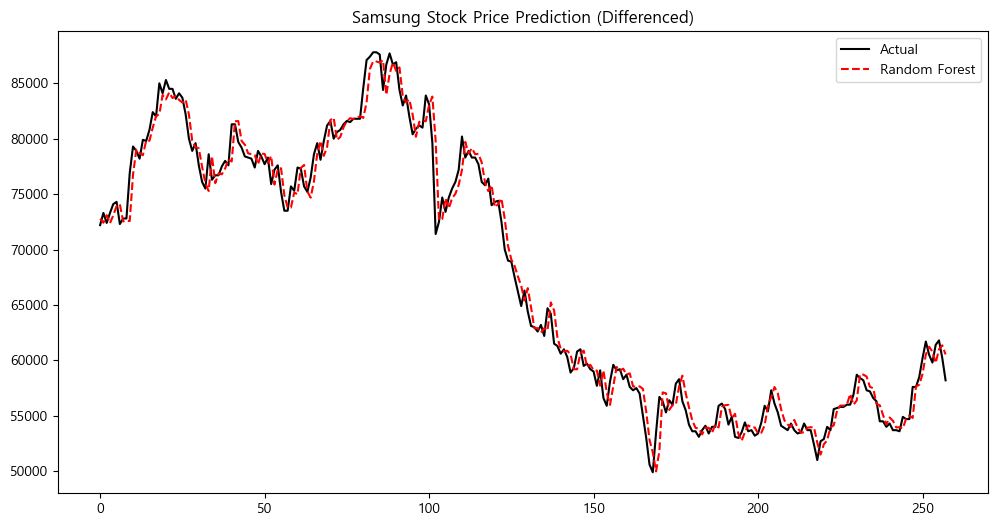

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test.values, label='Actual', color='black')
plt.plot(rf_pred, label='Random Forest', color='red', linestyle='dashed')
plt.legend()
plt.title("Samsung Stock Price Prediction (Differenced)")
plt.show()

In [73]:
tomorrow_features=X_test[-1:]  # X_test의 마지막 행 가져오기
tomorrow_prediction=rf_model.predict(tomorrow_features)
tomorrow_prediction

array([60531.35108149])

In [75]:
tomorrow_features

,Open,High,Low,Close
Date,,,,
2025-03-28,60700,61100,60000,60200


### 평균 이동
- 참조) https://positive-impactor.tistory.com/780

In [78]:
avg_stock=stock.copy()
avg_stock.shape

(1289, 6)

- 20개의 데이터 포인트를 기준으로 이동 평균을 계산

In [81]:
avg_stock['SAM_20']=avg_stock['Close'].rolling(window=20).mean()
avg_stock['SAM_50']=avg_stock['Close'].rolling(window=50).mean()
avg_stock.head(21)

,Open,High,Low,Close,Volume,Change,SAM_20,SAM_50
Date,,,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753,NaN,NaN
2020-01-03,56000,56600,54900,55500,15422255,0.005435,NaN,NaN
2020-01-06,54900,55600,54600,55500,10278951,0.000000,NaN,NaN
2020-01-07,55700,56400,55600,55800,10009778,0.005405,NaN,NaN
2020-01-08,56200,57400,55900,56800,23501171,0.017921,NaN,NaN
2020-01-09,58400,58600,57400,58600,24102579,0.031690,NaN,NaN
2020-01-10,58800,59700,58300,59500,16000170,0.015358,NaN,NaN
2020-01-13,59600,60000,59100,60000,11359139,0.008403,NaN,NaN
2020-01-14,60400,61000,59900,60000,16906295,0.000000,NaN,NaN


In [83]:
X=avg_stock[['SAM_20', 'SAM_50']]
X.shape

(1289, 2)

In [85]:
Y=avg_stock['Close'].shift(-1)       # 다음날의 종가를 예측
Y.tail()

Date
2025-03-25    61400.0
2025-03-26    61800.0
2025-03-27    60200.0
2025-03-28    58200.0
2025-03-31        NaN
Name: Close, dtype: float64

### 학습 및 평가

In [90]:
X_train, X_test, Y_train, Y_test=train_test_split(X[:-1], Y[:-1], test_size=0.2, random_state=42)

In [92]:
rf_model=RandomForestRegressor(max_depth=3)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=3)

In [94]:
rf_model.score(X_train, Y_train), rf_model.score(X_test, Y_test)

(0.9208079524056726, 0.923900638850768)

In [96]:
pred=rf_model.predict(X_test)
pred[-1]

80709.49562166675

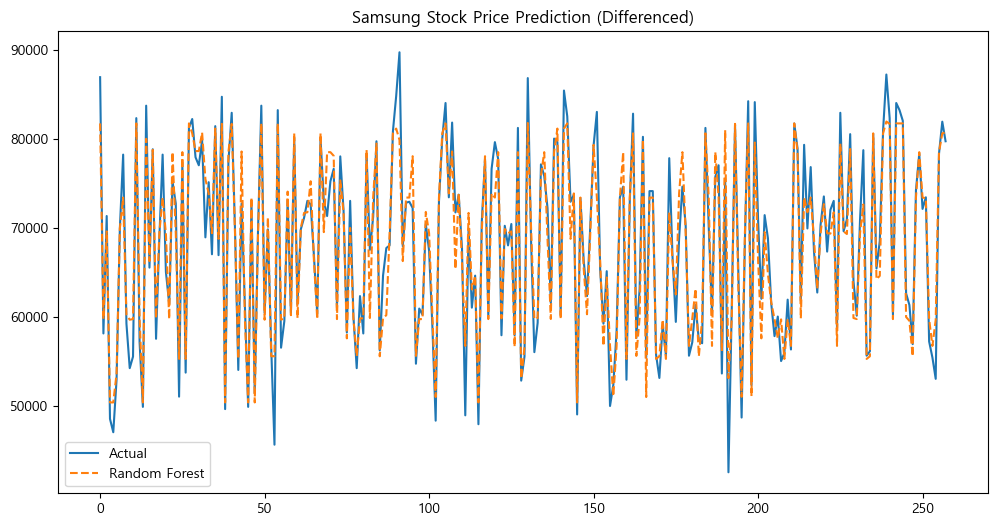

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test.values, label='Actual')
plt.plot(pred, label='Random Forest', linestyle='dashed')
plt.legend()
plt.title("Samsung Stock Price Prediction (Differenced)")
plt.show()